In [1]:
from keras.models  import load_model
import keras.backend as K

import cPickle
import sys
sys.path.insert(0, '../../preprocess')
import vectorizer

from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

aspects = ['population', 'intervention', 'outcome']

Using TensorFlow backend.


[]


In [2]:
pubmed_data = cPickle.load(open('../../pubmed/pubmed_data_vec_5000_dedup_n.p'))

In [3]:
df = pd.read_csv('../../pubmed/pubmed_data_dedup_n.csv').reset_index()

In [4]:
file_model = '../store/weights/single_setup/SatDec216:57:342017final1/loss.h5'
model = load_model(file_model, custom_objects={'contrastive_loss' : lambda a,b : a, '<lambda>' : lambda a,b : a})

In [5]:
model_aspect = {}
for aspect in aspects :
    model_aspect[aspect] = K.function(model.get_layer('pool_'+aspect[0].upper()).inputs + [K.learning_phase()], 
                          [model.get_layer('pool_'+aspect[0].upper()).get_output_at(0)])

In [6]:
topics = list(df['label'].unique())

In [7]:
X = {}
df_t = {}
for t in topics :
    index = df[df['label'] == t].index
    df_t[t] = df[df['label'] == t].reset_index()
    X[t] = pubmed_data.X[index, :]

In [8]:
embedds = {}
norm_embedds = {}
topic_scores = {}
for t in topics :
    pool_cdsr = {}
    norm_pool_cdsr = {}
    scores = {}
    X_abs = X[t]

    for aspect in aspects :
        pool_cdsr[aspect] = []
        for i in range(int(np.floor(len(X_abs)/1000)) + 1) :
            pool_cdsr[aspect].append(model_aspect[aspect]([X_abs[i*1000:(i+1)*1000,:], 0])[0])
        pool_cdsr[aspect] = np.concatenate(pool_cdsr[aspect])
        norm_pool_cdsr[aspect] = normalize(np.float64(pool_cdsr[aspect]), 'l2')
        scores[aspect] = np.dot(norm_pool_cdsr[aspect], norm_pool_cdsr[aspect].T)
        np.fill_diagonal(scores[aspect], -1000)
    
    embedds[t] = pool_cdsr
    norm_embedds[t] = norm_pool_cdsr
    topic_scores[t] = scores

In [9]:
topic = 'Arthroplasty, Replacement, Hip[mesh] Randomized Controlled Trial[ptyp]'

In [10]:
df_iain = pd.read_table('../../pubmed/Arthro_50_pubmed_IM.txt', encoding='utf-16')

In [11]:
vals = df_t[topic][df_t[topic]['idx'].isin(df_iain['idx'])]

In [12]:
iain_scores = {}
scores_iain = {}
for aspect in aspects :
    iain_scores[aspect] = norm_embedds[topic][aspect][vals.index]
    scores_iain[aspect] = topic_scores[topic][aspect][np.ix_(vals.index, vals.index)]

In [13]:
joined_df = vals.merge(df_iain, on='idx',suffixes=('_x', '_y'))

In [ ]:
vec = cPickle.load(open('../data/vectorizers/allfields_with_embedding_5000.p', 'rb'))

In [ ]:
irange = vec.index['abstract']
X_abs = vec.X[irange[0]:irange[1]]
pool_cdsr = {}
norm_pool_cdsr = {}

for aspect in aspects :
    pool_cdsr[aspect] = []
    for i in range(int(np.floor(len(X_abs)/500))) :
        pool_cdsr[aspect].append(model_aspect[aspect]([X_abs[i*1000:(i+1)*1000,:], 0])[0])
    pool_cdsr[aspect] = np.concatenate(pool_cdsr[aspect])
    norm_pool_cdsr[aspect] = normalize(np.float64(pool_cdsr[aspect]), 'l2')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
pca_models = {}
for aspect in aspects :
    pca = PCA(n_components=2, svd_solver='arpack', tol=0.0000001)
    #data = np.concatenate([norm_pool_cdsr[aspect], iain_scores[aspect]], axis=0)
    data = norm_pool_cdsr[aspect]
    pca.fit(data)
    pca_models[aspect] = pca
    
pcas = {}
for aspect in aspects :
    pcas[aspect] = pca_models[aspect].transform(iain_scores[aspect])

In [ ]:
import matplotlib.pyplot as plt
for aspect in aspects :
    keys = joined_df['assignment'].unique()
    for key in keys :
        idxs = joined_df[joined_df['assignment'] == key].index
        plt.scatter(pcas[aspect][idxs, 0], pcas[aspect][idxs, 1], label=key)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks([])
    plt.yticks([])
    plt.title(aspect)
    plt.savefig('../store/pca_pubmed_' + aspect + '.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsnes = {}
for aspect in aspects :
    tsnes[aspect] = TSNE(n_components=2, metric='precomputed').fit_transform(2*(1 - scores_iain[aspect]))

In [ ]:
import matplotlib.pyplot as plt
for aspect in aspects :
    keys = joined_df['assignment'].unique()
    for key in keys :
        idxs = joined_df[joined_df['assignment'] == key].index
        plt.scatter(tsnes[aspect][idxs, 0], tsnes[aspect][idxs, 1], label=key)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks([])
    plt.yticks([])
    plt.title(aspect)
    plt.savefig('../store/tsne_pubmed_' + aspect + '.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [14]:
da = joined_df
nb_studies = len(joined_df)
H = np.zeros((nb_studies, nb_studies))
for i in range(nb_studies) :
    H[i, da[da['assignment'] == da['assignment'][i]].index] = 1
np.fill_diagonal(H, 0)

In [15]:
from sklearn.metrics import roc_auc_score
series = {}
for aspect in aspects :
    aucs = [0] * nb_studies
    for i in range(nb_studies) :
        if sum(H[i]) > 0 :
            aucs[i] = roc_auc_score(H[i], scores_iain[aspect][i])
        else :
            aucs[i] = 0.5
    print aspect, np.mean(aucs)
    rocs = {}
    for key in da['assignment'].unique() :
        idxs = da[da['assignment'] == key].index
        rocs[key] = np.mean(np.array(aucs)[idxs])
    rocs['mean'] = np.mean(aucs)
    series[aspect] = pd.Series(rocs, name=aspect)
pd.DataFrame(series.values())

population 0.654537129537
intervention 0.572464202464
outcome 0.494469141969


,i,mean,p,unclear
outcome,0.725136,0.494469,0.419509,0.5
intervention,0.918998,0.572464,0.462033,0.5
population,0.571484,0.654537,0.685650,0.5


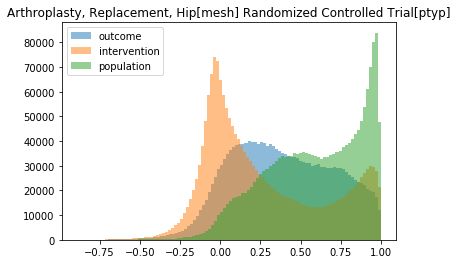

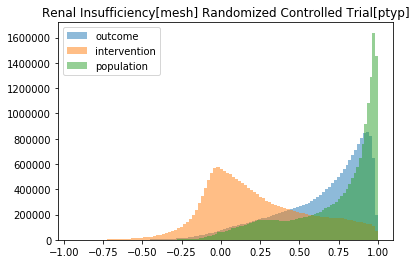

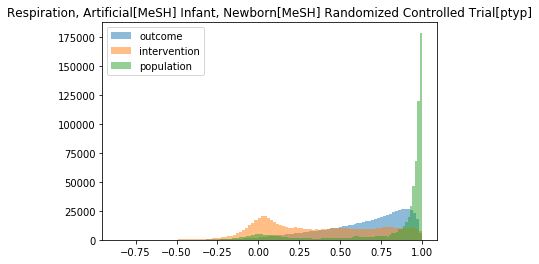

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in topics :
    for aspect in scores :
        s = topic_scores[i][aspect]
        vals = s[s >= -2].flatten()
        plt.hist(vals, bins=100, label=aspect, alpha=0.5)
    plt.legend()
    plt.title(i)
    plt.show()

In [ ]:
cov = np.cov(x_std.T)
ev , eig = np.linalg.eig(cov)
a = eig.dot(x_std.T)